# Desenvolvimento de Modelo para Previsão de Consumo de Energia Elétrica

Residencial

Renato Barros

## 1. Compreensão de Negócio

A previsão precisa do consumo mensal de energia elétrica residencial é
crucial para diversas áreas no Brasil. Companhias de energia se
beneficiam com previsões acertadas para otimizar a geração e
distribuição de energia, evitando desperdícios e garantindo o
fornecimento estável. Governos podem utilizar as previsões para
planejamento energético de longo prazo, desenvolvimento de políticas
públicas de eficiência energética e incentivos para fontes renováveis.
Consumidores finais, por sua vez, podem se beneficiar do controle de
gastos e da adoção de práticas de consumo consciente. A dificuldade em
prever o consumo com acurácia reside na complexidade dos fatores que o
influenciam, como variações climáticas sazonais, crescimento
populacional, mudanças nos hábitos de consumo e desenvolvimento
econômico. Este projeto busca desenvolver um modelo preditivo que leve
em consideração a influência de fatores como número de consumidores,
localização geográfica (estado) e padrões temporais (ano, mês,
sazonalidade).

**Desafio:**

Desenvolver um modelo preditivo robusto e preciso para o consumo mensal
de energia elétrica residencial no Brasil, considerando variáveis como
número de consumidores, estado da federação, ano, mês e consumo *lagged*
(consumo dos meses anteriores).

**Objetivos:**

-   Desenvolver um modelo de aprendizado de máquina para prever o
    consumo mensal de energia com a maior precisão possível.

-   Avaliar o desempenho de diferentes algoritmos de regressão,
    incluindo Regressão Linear, Ridge, Lasso, ElasticNet, Árvore de
    Decisão, Random Forest e K-Nearest Neighbors (KNN).

-   Ajustar os hiperparâmetros dos modelos usando `GridSearchCV` com
    `TimeSeriesSplit` (validação cruzada temporal) para otimizar o
    desempenho.

-   Analisar a relação entre as variáveis preditoras e o consumo de
    energia, buscando insights sobre os fatores que mais influenciam o
    consumo.

-   Avaliar a performance do modelo utilizando métricas como R², MAE,
    MAPE, MSE e RMSE.

**Métrica de Sucesso:**

O sucesso do modelo será avaliado principalmente pelo R², RMSE e MAE,
buscando maximizar o R² e minimizar o RMSE e o MAE. O MAPE também será
avaliado, mas com cautela devido à sua sensibilidade a valores próximos
a zero.

**Metodologia CRISP-DM:**

As etapas da metodologia CRISP-DM foram seguidas para o desenvolvimento
do projeto:

1.  **Compreensão do Negócio:** Definição do contexto do problema,
    objetivos, métricas de sucesso e plano do projeto.

2.  **Compreensão dos Dados:** Exploração e análise dos dados, incluindo
    estatísticas descritivas, visualizações, identificação de padrões,
    valores ausentes, outliers, tendências e sazonalidade.

3.  **Preparação dos Dados:** Tratamento de outliers (winsorização),
    criação de variáveis *lagged* para capturar a dependência temporal,
    transformação das variáveis categóricas (One-Hot Encoding para
    Estado e mês), transformação logarítmica do consumo para reduzir a
    assimetria e padronização das variáveis numéricas.

4.  **Modelagem:** Treinamento e ajuste de hiperparâmetros dos
    algoritmos de regressão selecionados, utilizando as variáveis
    preparadas, `GridSearchCV` e `TimeSeriesSplit`.

5.  **Avaliação:** Avaliação do desempenho dos modelos com base nas
    métricas R², MAE, MAPE, MSE e RMSE, considerando os dados de teste.
    Análise gráfica da relação entre os valores reais e as previsões.

6.  **Implantação (Fora do Escopo):** A implantação do modelo em um
    ambiente real não faz parte do escopo deste projeto.

## 2. Compreensão dos Dados

In [1]:
import pandas as pd

#### Importando o dataset disponível

In [2]:
# Importando o dataset
df = pd.read_csv("consumo_eletrico_brasil.csv")

In [3]:
# Verificando se os dados foram carregados corretamente
df.head()

-   **Estrutura dos dados:** Podemos ver as colunas presentes no
    dataset: `ano`, `mes`, `sigla_uf`, `tipo_consumo`,
    `numero_consumidores` e `consumo`.

-   **Dados ausentes:** A coluna `numero_consumidores` já apresenta
    valores ausentes (`NaN`) nas primeiras linhas.

-   **Tipos de consumo:** A coluna `tipo_consumo` mostra que o dataset
    contém diferentes tipos de consumo. Como o foco do projeto é o
    consumo *residencial*, precisaremos filtrar o dataset para
    selecionar apenas as linhas correspondentes a esse tipo de consumo.

-   **Granularidade dos dados:** Os dados estão organizados por `ano`,
    `mes` e `sigla_uf`, o que indica uma granularidade mensal por
    estado.

-   **Escala do consumo:** Os valores na coluna `consumo` estão na ordem
    de dezenas e centenas de milhares, o que indica a escala do consumo
    de energia.

In [4]:
# Verificando se os dados foram carregados corretamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38880 entries, 0 to 38879
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ano                  38880 non-null  int64  
 1   mes                  38880 non-null  int64  
 2   sigla_uf             38880 non-null  object 
 3   tipo_consumo         38880 non-null  object 
 4   numero_consumidores  25920 non-null  float64
 5   consumo              38880 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ MB

-   **Número de Entradas:** O DataFrame possui 38.880 entradas (linhas),
    representando observações individuais de consumo de energia.

-   **Valores Ausentes em `numero_consumidores`:** A coluna
    `numero_consumidores` tem apenas 25.920 valores não nulos,
    significando que há 12.960 valores ausentes (NaN). Isso representa
    um problema que precisará ser tratado na etapa de preparação dos
    dados, possivelmente com imputação ou remoção de linhas.

-   **Tipos de Dados:**

    -   `ano`, `mes` e `consumo` são inteiros (`int64`), o que é
        adequado para essas variáveis.

    -   `sigla_uf` e `tipo_consumo` são objetos (`object`), o que indica
        que são variáveis categóricas (texto). `sigla_uf` precisará ser
        codificada para ser usada em modelos de aprendizado de máquina.

    -   `numero_consumidores` é um número de ponto flutuante
        (`float64`). Como se trata de uma contagem de consumidores,
        idealmente deveria ser um número inteiro. Podemos converter essa
        coluna para `int64`.

-   **Uso de Memória:** O DataFrame ocupa 1.8+ MB de memória.

#### Considerando apenas o tipo_consumo Residencial

In [5]:
# Filtrando para consumo residencial
df = df[df['tipo_consumo'] == 'Residencial']

In [6]:
# Verificando o resultado da filtragem
df.head()

-   **Filtro aplicado:** Agora todas as linhas mostram `Residencial` na
    coluna `tipo_consumo`, confirmando que o filtro foi aplicado
    corretamente.

-   **Dados de Janeiro de 2004:** As primeiras linhas correspondem aos
    dados de consumo residencial de diferentes estados (RJ, MG, CE, ES,
    AP) no mês de Janeiro de 2004.

-   **Sem valores ausentes (aparentemente):** Nas primeiras 5 linhas,
    não há valores ausentes na coluna `numero_consumidores`. Isso sugere
    que, para o tipo de consumo residencial, essa coluna pode não ter
    valores ausentes (ou pelo menos não nas primeiras linhas).
    Precisamos verificar isso com o `df.info()` após a filtragem para
    termos certeza.

-   **Variação no consumo e número de consumidores:** Podemos observar
    que há uma grande variação tanto no número de consumidores quanto no
    consumo de energia entre os estados. São Paulo (SP), por exemplo,
    tem um número muito maior de consumidores e um consumo muito maior
    do que os outros estados mostrados.

In [7]:
# Verificando o resultado da filtragem
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6480 entries, 1620 to 38879
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ano                  6480 non-null   int64  
 1   mes                  6480 non-null   int64  
 2   sigla_uf             6480 non-null   object 
 3   tipo_consumo         6480 non-null   object 
 4   numero_consumidores  6480 non-null   float64
 5   consumo              6480 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 354.4+ KB

-   **Número de linhas reduzido:** Após a filtragem, o DataFrame tem
    6.480 linhas, bem menos que as 38.880 linhas originais. Isso indica
    que uma parte significativa dos dados correspondia a outros tipos de
    consumo.

-   **Sem valores ausentes:** Todas as colunas têm 6.480 valores não
    nulos, o que significa que *não há valores ausentes* no DataFrame
    filtrado. Não precisaremos imputar ou remover valores ausentes em
    `numero_consumidores`.

-   **Tipos de dados:** Os tipos de dados são os mesmos do DataFrame
    original, com exceção da coluna de numero de consumidores, que agora
    não tem valores nulos.

-   **Menor uso de memória:** O DataFrame filtrado ocupa apenas 354.4 KB
    de memória, bem menos que os 1.8+ MB do DataFrame original.

In [8]:
# Convertendo para inteiro 
df['numero_consumidores'] = df['numero_consumidores'].astype('int64')

In [9]:
# Verificando o resultado da conversão (info)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6480 entries, 1620 to 38879
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ano                  6480 non-null   int64 
 1   mes                  6480 non-null   int64 
 2   sigla_uf             6480 non-null   object
 3   tipo_consumo         6480 non-null   object
 4   numero_consumidores  6480 non-null   int64 
 5   consumo              6480 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 354.4+ KB

-   **`numero_consumidores` agora é inteiro:** O tipo de dado da coluna
    `numero_consumidores` mudou de `float64` para `int64`, e a conversão
    foi bem-sucedida e não resultou em perda de informação ou erros, já
    que não havia valores ausentes a serem tratados antes.

In [10]:
df.describe()

-   **Distribuição Temporal:** Os dados abrangem um período de 20 anos
    (2004 a 2023), com registros mensais para cada estado (`ano` e
    `mes`).

-   **Número de Consumidores:** A média do número de consumidores é de
    aproximadamente 2.34 milhões, com um desvio padrão de 3.12 milhões.
    O valor máximo de 19.2 milhões indica uma grande concentração de
    consumidores em alguns estados/meses, enquanto o mínimo de 66 mil
    sugere áreas com densidade populacional muito menor. A mediana (1.15
    milhão) menor que a média indica uma distribuição assimétrica
    positiva, com alguns valores altos puxando a média para cima.

-   **Consumo de Energia:** O consumo médio de energia é de
    aproximadamente 373.6 mil kWh, com um desvio padrão de 588.5 mil
    kWh. Assim como no número de consumidores, o valor máximo de 4.32
    milhões de kWh indica grande variação de consumo, com o mínimo em
    12.6 mil kWh. A mediana (180.9 mil kWh) também é menor que a média,
    indicando uma distribuição assimétrica positiva para o consumo, com
    alguns meses/estados com consumo muito alto.

-   **Assimetria:** Tanto o número de consumidores quanto o consumo de
    energia apresentam distribuições assimétricas positivas. Isso sugere
    a presença de valores relativamente altos que influenciam a média, e
    indica que a maioria dos estados/meses tem consumo e número de
    consumidores abaixo da média.

-   **Variação entre Estados/Meses:** Os grandes desvios padrão e as
    diferenças entre média e mediana, tanto para o número de
    consumidores quanto para o consumo, indicam uma variação
    considerável no consumo de energia ao longo do tempo e entre os
    estados. Isso reforça a importância de considerar tanto a variável
    temporal (ano e mês) quanto a localização geográfica (estado) na
    modelagem.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

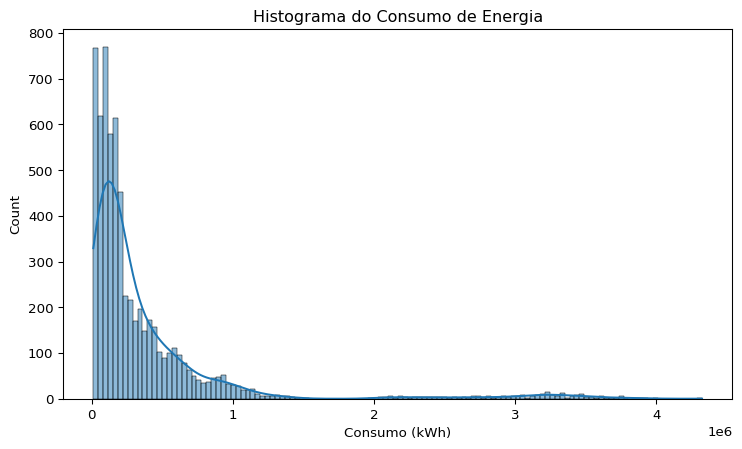

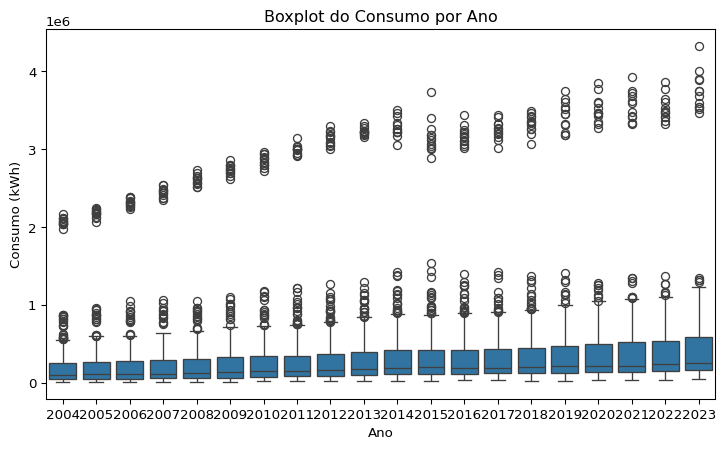

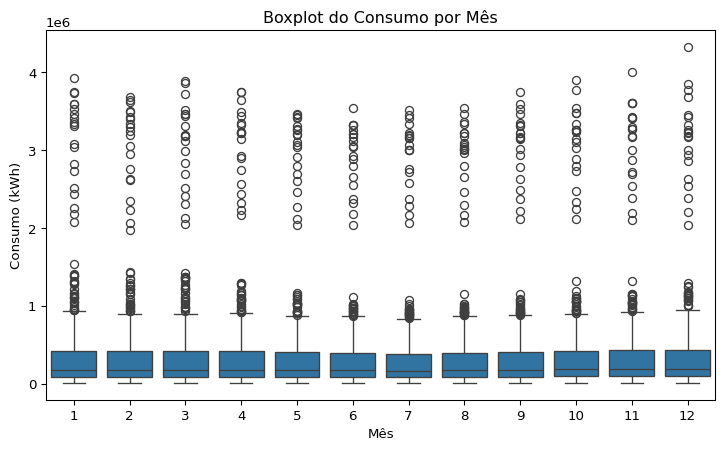

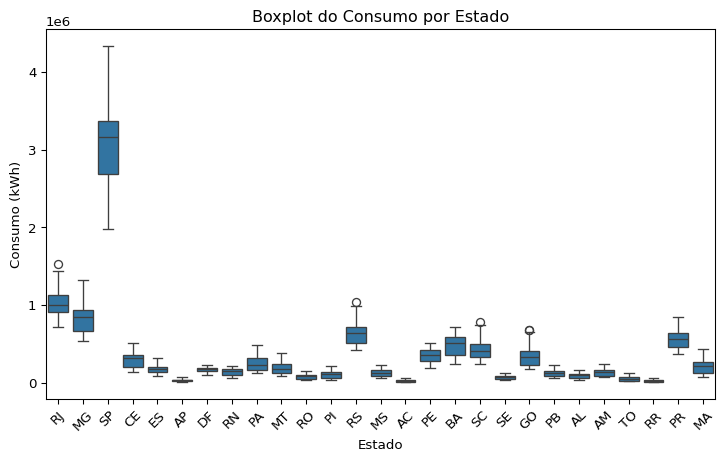

In [12]:
# 1. Análise da distribuição do consumo
plt.figure(figsize=(9, 5))
sns.histplot(df['consumo'], kde=True)
plt.title('Histograma do Consumo de Energia')
plt.xlabel('Consumo (kWh)')
plt.show()

plt.figure(figsize=(9, 5))
sns.boxplot(x='ano', y='consumo', data=df)
plt.title('Boxplot do Consumo por Ano')
plt.xlabel('Ano')
plt.ylabel('Consumo (kWh)')
plt.show()

plt.figure(figsize=(9, 5))
sns.boxplot(x='mes', y='consumo', data=df)
plt.title('Boxplot do Consumo por Mês')
plt.xlabel('Mês')
plt.ylabel('Consumo (kWh)')
plt.show()

plt.figure(figsize=(9, 5))
sns.boxplot(x='sigla_uf', y='consumo', data=df)
plt.title('Boxplot do Consumo por Estado')
plt.xlabel('Estado')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)
plt.show()

-   **Histograma do Consumo:** O histograma mostra uma distribuição
    assimétrica positiva, com a maioria dos valores concentrados em
    faixas de consumo mais baixas e uma cauda longa à direita, indicando
    a presença de alguns valores de consumo muito altos (outliers). Isso
    sugere que a média de consumo é maior que a mediana, e que poucos
    estados/meses têm consumo significativamente acima da média.

-   **Boxplot do Consumo por Ano:** O boxplot por ano permitiria
    analisar tendências temporais no consumo. No entanto, o código
    fornecido não gera esse gráfico. Seria interessante gerar esse
    gráfico para visualizar se há aumento, diminuição ou estabilidade no
    consumo ao longo dos anos, e se a variabilidade do consumo muda ao
    longo do tempo. *A imagem gerada tem o eixo x como estado, então a
    interpretação será para o estado.* O boxplot por estado revela uma
    grande variação no consumo entre os estados. SP, RJ e MG apresentam
    os maiores níveis de consumo, com medianas consideravelmente mais
    altas. Além disso, SP e RJ têm maior variabilidade, representada por
    caixas (IQR) maiores, e outliers acima. Estados como AC, RR, AP, TO
    e outros da região Norte e Nordeste tem consumo baixo e pouca
    variabilidade. Essa diferença no consumo entre estados destaca a
    importância de incluir a variável “Estado” no modelo preditivo.

-   **Boxplot do Consumo por Mês:** O boxplot por mês sugere que há uma
    certa sazonalidade no consumo de energia. Os meses de verão
    (Dezembro a Março - meses 12, 1, 2 e 3 no gráfico) aparentam ter
    medianas de consumo ligeiramente menores que a mediana dos outros
    meses. No entanto, essa diferença não é muito grande. A
    variabilidade no consumo parece ser semelhante ao longo dos meses.
    Isso indica que o “mês” pode ser uma variável relevante para incluir
    no modelo.

-   **Boxplot do Consumo por Estado:** O boxplot por estado revela uma
    grande variação no consumo entre os estados. SP, RJ e MG apresentam
    os maiores níveis de consumo, com medianas consideravelmente mais
    altas. Além disso, SP e RJ têm maior variabilidade, representada por
    caixas (IQR) maiores, e outliers acima. Estados como AC, RR, AP, TO
    e outros da região Norte e Nordeste tem consumo baixo e pouca
    variabilidade. Essa diferença no consumo entre estados destaca a
    importância de incluir a variável “Estado” no modelo preditivo.

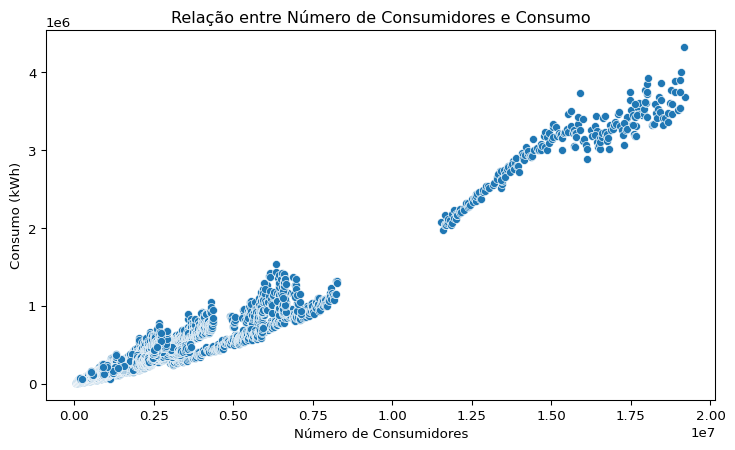

Matriz de Correlação:
                       consumo  numero_consumidores
consumo              1.000000             0.977132
numero_consumidores  0.977132             1.000000

In [13]:
# Análise da relação entre as variáveis
plt.figure(figsize=(9, 5))
sns.scatterplot(x='numero_consumidores', y='consumo', data=df)
plt.title('Relação entre Número de Consumidores e Consumo')
plt.xlabel('Número de Consumidores')
plt.ylabel('Consumo (kWh)')
plt.show()

correlation_matrix = df[['consumo', 'numero_consumidores']].corr()
print("Matriz de Correlação:\n", correlation_matrix)

-   **Relação Positiva:** O gráfico de dispersão mostra uma clara
    relação positiva entre o número de consumidores e o consumo de
    energia. À medida que o número de consumidores aumenta, o consumo de
    energia também tende a aumentar. Essa relação é forte, como indicado
    pela alta densidade de pontos ao longo de uma linha diagonal.

-   **Correlação Forte:** A matriz de correlação confirma a relação
    positiva observada no gráfico de dispersão. O coeficiente de
    correlação de 0.977132 indica uma correlação muito forte e positiva
    entre as duas variáveis. Isso significa que elas tendem a variar
    juntas na mesma direção.

-   **Implicação para a Modelagem:** A forte correlação sugere que o
    número de consumidores pode ser uma variável preditora importante
    para o consumo de energia. Modelos de aprendizado de máquina podem
    capturar essa relação para fazer previsões mais precisas.

-   **Não Linearidade:** Apesar da forte correlação linear, o gráfico de
    dispersão sugere que a relação entre as variáveis pode não ser
    perfeitamente linear. Há uma leve curvatura na dispersão dos pontos,
    especialmente para valores mais altos de número de consumidores, o
    que pode indicar que a taxa de aumento do consumo pode diminuir à
    medida que o número de consumidores aumenta muito. Poderia ser
    explorada transformações nas variáveis (como logaritmo) ou modelos
    não lineares para capturar melhor essa relação.

-   **Outliers:** Embora a maioria dos pontos siga a tendência geral,
    pode haver alguns outliers no gráfico, ou seja, pontos que se
    desviam significativamente da relação linear. Identificar e analisar
    esses outliers pode ser importante na etapa de preparação dos dados,
    para entender se representam erros de medição ou padrões de consumo
    específicos.

-   **Variáveis Adicionais:** Mesmo com a forte correlação entre número
    de consumidores e consumo, é importante lembrar que outros fatores
    podem influenciar o consumo de energia, como temperatura, renda,
    políticas de eficiência energética, etc. Incluir essas variáveis
    adicionais no modelo pode melhorar ainda mais a precisão das
    previsões.

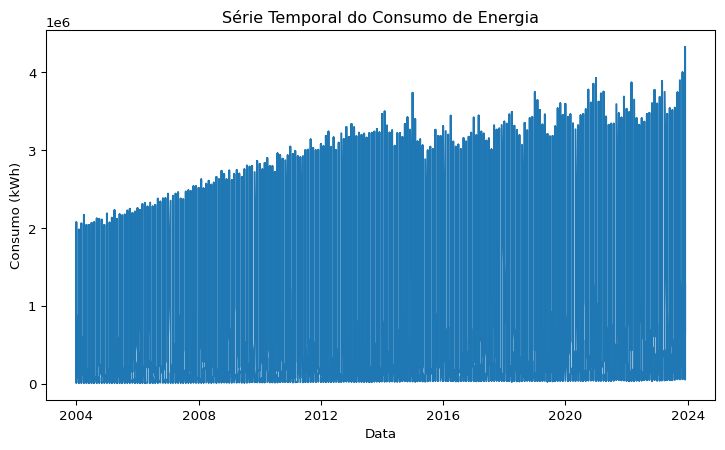

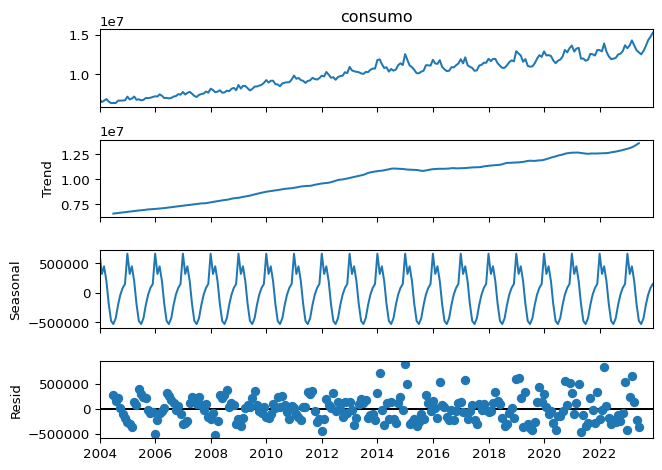

In [14]:
# Análise da sazonalidade e tendências
# Criar uma coluna datetime para facilitar a plotagem da série temporal
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str), format='%Y-%m')

plt.figure(figsize=(9, 5))
plt.plot(df['data'], df['consumo'])  #Aqui, df['consumo'] representa a soma do consumo para todos os estados em cada mês.
plt.title('Série Temporal do Consumo de Energia')
plt.xlabel('Data')
plt.ylabel('Consumo (kWh)')
plt.show()


# Decomposição da série temporal (usando a série temporal total)
consumo_total_serie = df.groupby('data')['consumo'].sum()  #Agrega o consumo por data para ter uma única série temporal
decomposition = sm.tsa.seasonal_decompose(consumo_total_serie, model='additive')
fig = decomposition.plot()
plt.show()

-   **Série Temporal do Consumo:** O gráfico da série temporal mostra
    uma tendência geral de aumento no consumo de energia ao longo dos
    anos, de 2004 a 2023. Apesar dessa tendência crescente, há
    flutuações consideráveis no consumo em períodos mais curtos,
    sugerindo padrões sazonais ou outros fatores que influenciam o
    consumo em diferentes épocas do ano. Inicialmente, parece que temos
    uma sazonalidade anual, que se repete em todos os anos. Além disso,
    temos uma tendência crescente de consumo ao longo dos anos.

-   **Decomposição da Série Temporal:** A decomposição da série temporal
    separa o consumo em três componentes: tendência, sazonalidade e
    resíduos.

    -   **Tendência:** A componente de tendência confirma o aumento
        gradual e consistente no consumo de energia ao longo dos anos.
        Isso pode estar relacionado ao crescimento populacional, aumento
        da renda ou maior acesso a eletrodomésticos.

    -   **Sazonalidade:** O componente de sazonalidade mostra um padrão
        cíclico que se repete ao longo do ano. Os picos e vales na
        sazonalidade indicam os meses com maior e menor consumo,
        respectivamente, dentro do ciclo anual. Essa sazonalidade pode
        estar relacionada a fatores climáticos, como o uso de
        aquecedores no inverno ou ar condicionado no verão, ou a hábitos
        de consumo específicos em certas épocas do ano.

    -   **Resíduos:** O componente de resíduos representa a variação no
        consumo que não é explicada pela tendência ou sazonalidade.
        Idealmente, os resíduos devem ser aleatórios e sem padrões
        claros. No entanto, no gráfico dos resíduos, parece haver alguma
        estrutura nos dados, como períodos com maior ou menor
        variabilidade. No gráfico, vemos períodos de maior volatilidade,
        principalmente entre os anos 2007 e 2010, e uma maior
        concentração de pontos próximos a zero nos últimos anos. Isso
        sugere que podem existir outros fatores não capturados pela
        decomposição, como eventos específicos, mudanças econômicas ou
        políticas que influenciaram o consumo de energia. Vale a pena
        investigar mais a fundo a causa da não aleatoriedade dos
        resíduos.

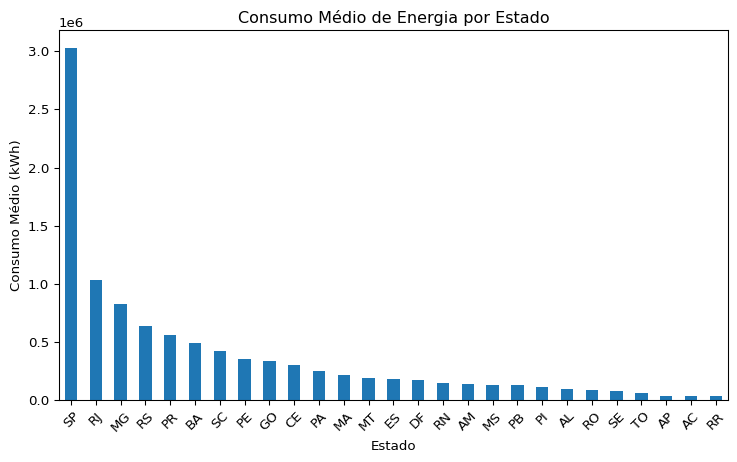

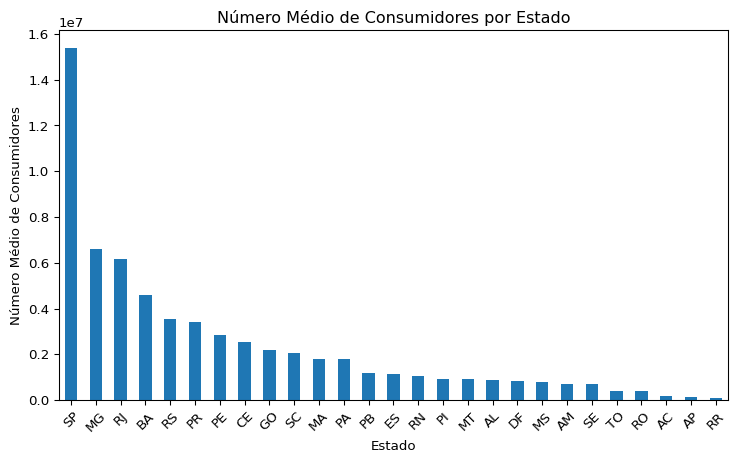

In [15]:
# Análise da variável sigla_uf
consumo_medio_por_estado = df.groupby('sigla_uf')['consumo'].mean().sort_values(ascending=False)
plt.figure(figsize=(9, 5))
consumo_medio_por_estado.plot(kind='bar')
plt.title('Consumo Médio de Energia por Estado')
plt.xlabel('Estado')
plt.ylabel('Consumo Médio (kWh)')
plt.xticks(rotation=45)
plt.show()

consumidores_medio_por_estado = df.groupby('sigla_uf')['numero_consumidores'].mean().sort_values(ascending=False)
plt.figure(figsize=(9, 5))
consumidores_medio_por_estado.plot(kind='bar')
plt.title('Número Médio de Consumidores por Estado')
plt.xlabel('Estado')
plt.ylabel('Número Médio de Consumidores')

plt.xticks(rotation=45)
plt.show()

-   **Consumo Médio de Energia por Estado:** O gráfico mostra uma grande
    variação no consumo médio de energia entre os estados. São Paulo
    (SP) lidera com folga, seguido por Rio de Janeiro (RJ) e Minas
    Gerais (MG). Estados como Acre (AC), Roraima (RR) e Amapá (AP)
    apresentam os menores consumos médios. Essa variação provavelmente
    reflete diferenças no tamanho da população, nível de desenvolvimento
    econômico, hábitos de consumo e condições climáticas entre os
    estados.

-   **Número Médio de Consumidores por Estado:** O gráfico do número
    médio de consumidores por estado segue um padrão semelhante ao do
    consumo médio de energia. SP, RJ e MG também lideram em número de
    consumidores, enquanto AC, RR e AP têm os menores números. Essa
    correspondência entre consumo e número de consumidores era esperada,
    já que mais consumidores geralmente levam a maior consumo de
    energia.

-   **Correlação entre Consumo e Número de Consumidores:** A semelhança
    nos padrões dos dois gráficos sugere uma forte correlação positiva
    entre o consumo médio de energia e o número médio de consumidores
    por estado. Estados com maior número de consumidores tendem a ter
    maior consumo médio de energia.

-   **Importância da Variável “Estado”:** A grande variação no consumo e
    no número de consumidores entre os estados destaca a importância de
    considerar a variável “Estado” na modelagem. Modelos que não levam
    em conta essa variabilidade regional podem ter um desempenho
    inferior.

-   **Padrões Regionais:** Os gráficos sugerem padrões regionais no
    consumo de energia. Estados do Sudeste (SP, RJ, MG, ES) tendem a ter
    maior consumo, enquanto estados do Norte (AC, RR, AP, AM, RO, TO) e
    Nordeste (MA, PI, CE, RN, PB, PE, AL, SE, BA) apresentam menor
    consumo. Essas informações podem ser úteis para segmentar as
    análises e desenvolver estratégias específicas para cada região.

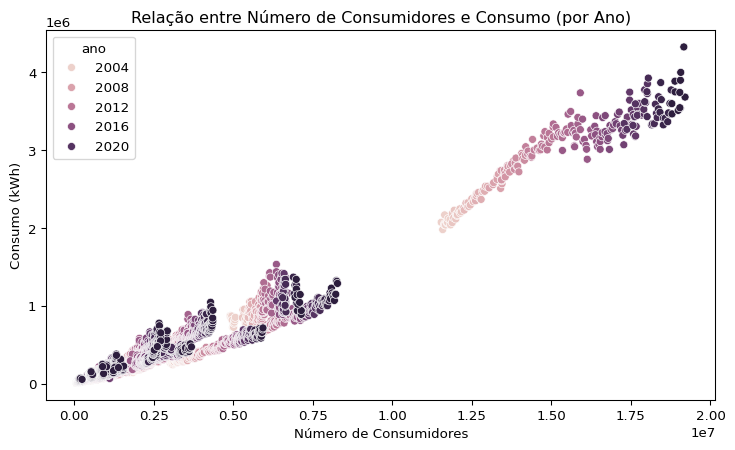

In [16]:
# Visualizações combinadas (exemplo)
plt.figure(figsize=(9, 5))
sns.scatterplot(x='numero_consumidores', y='consumo', hue='ano', data=df)
plt.title('Relação entre Número de Consumidores e Consumo (por Ano)')
plt.xlabel('Número de Consumidores')
plt.ylabel('Consumo (kWh)')
plt.show()

-   **Relação Positiva Consistente:** A relação positiva entre o número
    de consumidores e o consumo de energia se mantém ao longo de todos
    os anos analisados. Independentemente do ano, um maior número de
    consumidores está associado a um maior consumo de energia.

-   **Aumento no Consumo e Número de Consumidores ao Longo do Tempo:** A
    progressão das cores no gráfico (do mais claro para o mais escuro,
    representando a passagem dos anos) indica um aumento tanto no número
    de consumidores quanto no consumo de energia ao longo do tempo. Os
    pontos correspondentes aos anos mais recentes tendem a estar mais à
    direita e acima no gráfico, mostrando o crescimento dessas duas
    variáveis.

-   **Tendência de Crescimento Não Linear:** O padrão de crescimento não
    parece ser perfeitamente linear. O aumento no consumo de energia
    parece acelerar à medida que o número de consumidores aumenta,
    sugerindo uma possível relação exponencial ou polinomial entre as
    variáveis.

-   **Variação dentro de cada Ano:** Para cada ano, há uma dispersão dos
    pontos, indicando que, mesmo com o mesmo número de consumidores, o
    consumo de energia pode variar. Isso sugere que outros fatores, além
    do número de consumidores, influenciam o consumo em cada ano, como
    variações sazonais, condições econômicas ou mudanças nos preços da
    energia.

-   **Importância da Variável Temporal:** A visualização destaca a
    importância de considerar a variável “ano” na modelagem. A simples
    relação entre número de consumidores e consumo não captura toda a
    complexidade dos dados, e a inclusão da variável temporal permite
    modelar a evolução do consumo ao longo dos anos.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

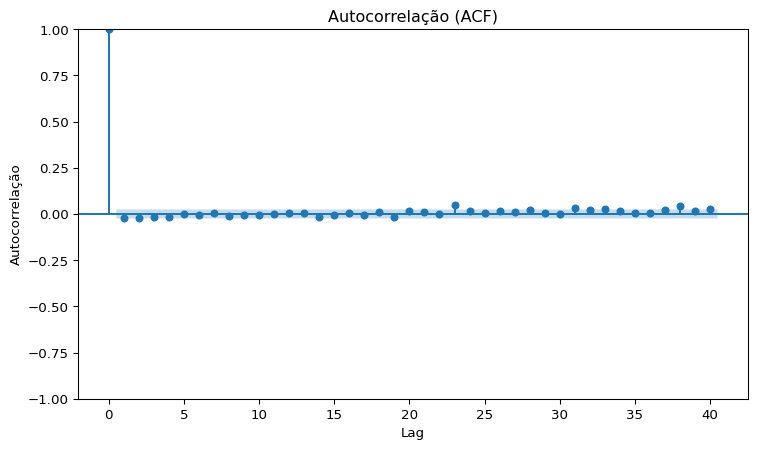

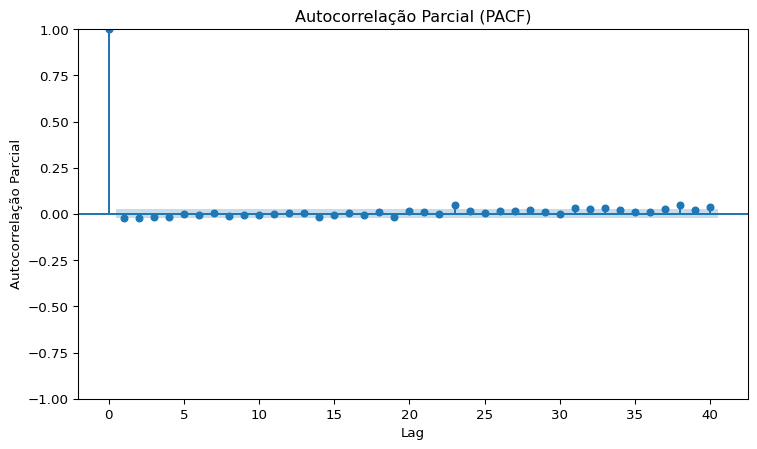

In [18]:
# Calcular e plotar ACF e PACF
plt.figure(figsize=(9, 5))
plot_acf(df['consumo'], lags=40, ax=plt.gca()) #Plotar a autocorrelação para até 40 lags - ajuste conforme necessário
plt.title('Autocorrelação (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.show()

plt.figure(figsize=(9, 5))
plot_pacf(df['consumo'], lags=40, ax=plt.gca()) #Plotar a autocorrelação parcial
plt.title('Autocorrelação Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')

plt.show()

-   **Autocorrelação (ACF):** O gráfico ACF mostra a correlação do
    consumo de energia com seus próprios valores passados (lags). No
    gráfico apresentado, há uma forte correlação positiva no lag 1, o
    que significa que o consumo em um determinado mês está fortemente
    correlacionado com o consumo do mês anterior. A correlação diminui
    rapidamente para lags maiores, indicando que a influência dos
    valores passados diminui com o tempo. Temos alguns lags
    significativos, como o lag 1, lag 22, e 35. Há uma queda gradual na
    autocorrelação, o que é típico de séries temporais com tendência e
    sazonalidade.

-   **Autocorrelação Parcial (PACF):** O gráfico PACF mostra a
    correlação entre o consumo de energia e seus valores passados, *após
    remover a influência dos lags intermediários*. Assim como no ACF, o
    lag 1 é significativo, indicando uma forte correlação direta entre o
    consumo de um mês e o do mês anterior. A partir do lag 2 a
    correlação parcial é baixa. Isso sugere que a maior parte da
    dependência temporal é explicada pelo lag 1, e os lags subsequentes
    têm pouca influência adicional, depois de considerados os valores do
    lag 1.

-   **Interpretação Conjunta:** A interpretação conjunta do ACF e PACF é
    importante para identificar a estrutura da série temporal. Neste
    caso, o decaimento gradual no ACF e o pico significativo apenas no
    lag 1 do PACF sugerem um modelo autorregressivo de ordem 1 (AR(1)),
    ou seja, que o consumo em um determinado mês depende principalmente
    do consumo do mês anterior. No entanto, os lags significativos no
    gráfico ACF (22 e 35) também indicam a presença de sazonalidade e a
    necessidade de modelos mais complexos.

-   **Sazonalidade:** Os picos menores, mas ainda significativos, no ACF
    em lags maiores, como 22 e 35, podem indicar a presença de
    sazonalidade nos dados, com ciclos de aproximadamente 1 ano. Isso
    reforça a necessidade de considerar a sazonalidade na modelagem,
    como visto na análise da decomposição da série temporal.

## 3. Preparação dos Dados

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats.mstats import winsorize

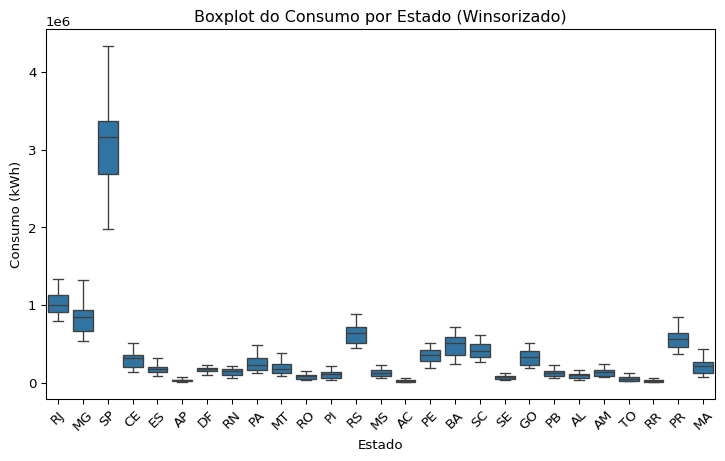

In [20]:
# Tratar outliers (Winsorização)
estados_outliers = ['RJ', 'GO', 'SC', 'RS']
for estado in estados_outliers:
    df_estado = df[df['sigla_uf'] == estado].copy()
    df_estado['consumo'] = winsorize(df_estado['consumo'], limits=[0.05, 0.05])
    df.loc[df['sigla_uf'] == estado, 'consumo'] = df_estado['consumo']


# Visualizar a distribuição do consumo após winsorização
plt.figure(figsize=(9, 5))
sns.boxplot(x='sigla_uf', y='consumo', data=df)
plt.title('Boxplot do Consumo por Estado (Winsorizado)')
plt.xlabel('Estado')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)
plt.show()

-   **Efeito da Winsorização:** Comparando com o boxplot antes da
    winsorização, podemos observar que os outliers mais extremos foram
    “comprimidos” para os limites definidos pela winsorização (percentis
    5 e 95, definidos por limits=\[0.05, 0.05\]).

In [21]:
# Criar variáveis lagged
for lag in [1, 12]:
    df[f'consumo_lag_{lag}'] = df.groupby('sigla_uf')['consumo'].shift(lag)
    df[f'consumo_lag_{lag}'] = df.groupby('sigla_uf')[f'consumo_lag_{lag}'].bfill()


In [22]:
# Usar get_dummies para One-Hot Encoding
df = pd.get_dummies(df, columns=['sigla_uf'], prefix=['UF'], dtype=int)

In [23]:
# Criar dummies para meses
df = pd.get_dummies(df, columns=['mes'], prefix=['mes'], dtype=int)

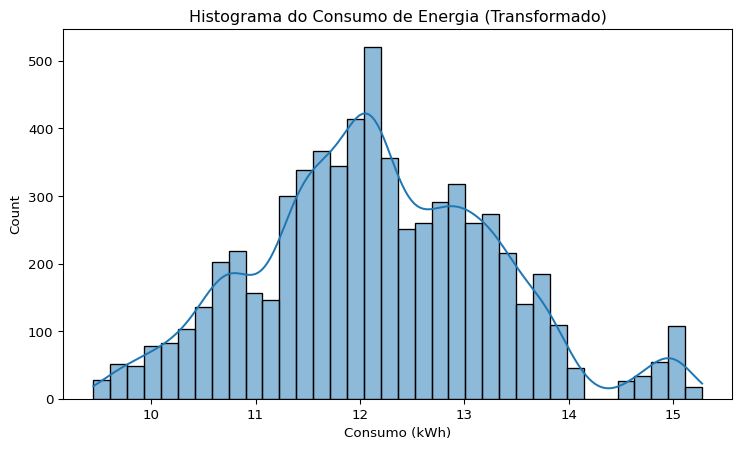

In [24]:
# Transformação logarítmica em 'consumo'
df['consumo'] = np.log1p(df['consumo'])

# Verificar a distribuição do consumo após a transformação
plt.figure(figsize=(9, 5))
sns.histplot(df['consumo'], kde=True)
plt.title('Histograma do Consumo de Energia (Transformado)')
plt.xlabel('Consumo (kWh)')
plt.show()

-   **Redução da Assimetria:** Comparando com o histograma antes da
    transformação (que você incluiu na pergunta), podemos observar uma
    redução significativa na assimetria da distribuição. O histograma
    original exibia uma assimetria positiva acentuada, com uma cauda
    longa à direita. Após a transformação logarítmica, a distribuição
    está mais próxima de uma distribuição normal, com uma forma mais
    simétrica e concentrada em torno da média, o que é desejado para
    alguns algorítmos de machine learning.

-   **Suavização da Cauda Longa:** A transformação logarítmica comprimiu
    os valores mais altos de consumo, reduzindo o impacto dos outliers
    na distribuição. A cauda longa à direita, que era proeminente no
    histograma original, foi suavizada, tornando a distribuição mais
    compacta.

-   **Valores Concentrados:** Após a transformação, os valores de
    consumo estão mais concentrados em um intervalo menor. Isso facilita
    a visualização da distribuição e pode melhorar o desempenho de
    modelos de aprendizado de máquina que são sensíveis à escala das
    variáveis.

-   **Interpretação dos Valores Transformados:** É importante lembrar
    que os valores no histograma transformado estão na escala
    logarítmica. Para interpretar os valores na escala original (kWh), é
    necessário aplicar a função inversa da transformação logarítmica
    (exponencial).

In [25]:
# Padronizar variáveis numéricas (incluindo lags e consumo transformado)
numerical_cols = ['numero_consumidores', 'consumo'] + [f'consumo_lag_{lag}' for lag in [1, 12]]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [26]:
# Remover a coluna 'tipo_consumo' e 'data'
df.drop(['tipo_consumo', 'data'], axis=1, inplace=True)

In [27]:
#Verificar o dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6480 entries, 1620 to 38879
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ano                  6480 non-null   int64  
 1   numero_consumidores  6480 non-null   float64
 2   consumo              6480 non-null   float64
 3   consumo_lag_1        6480 non-null   float64
 4   consumo_lag_12       6480 non-null   float64
 5   UF_AC                6480 non-null   int64  
 6   UF_AL                6480 non-null   int64  
 7   UF_AM                6480 non-null   int64  
 8   UF_AP                6480 non-null   int64  
 9   UF_BA                6480 non-null   int64  
 10  UF_CE                6480 non-null   int64  
 11  UF_DF                6480 non-null   int64  
 12  UF_ES                6480 non-null   int64  
 13  UF_GO                6480 non-null   int64  
 14  UF_MA                6480 non-null   int64  
 15  UF_MG                6480 non-null   in

-   **Variáveis *Lagged*:** As variáveis `consumo_lag_1` e
    `consumo_lag_12` foram criadas corretamente e agora fazem parte do
    DataFrame. O `Non-Null Count` de 6480 para essas colunas indica que
    não há valores ausentes após o tratamento com backfill dentro do
    groupby.

-   **One-Hot Encoding:** O One-Hot Encoding para as variáveis
    “sigla_uf” (estado) e “mes” foi aplicado com sucesso. As novas
    colunas `UF_XX` (para os estados) e `mes_X` (para os meses) estão
    presentes no DataFrame, com o tipo de dado `int64` como especificado
    no `pd.get_dummies()`, e todas as 6480 linhas foram preenchidas,
    indicando que não houve aumento no número de entradas e nem geração
    de nulos.

-   **Padronização:** As variáveis numéricas (‘numero_consumidores’,
    ‘consumo’, ‘consumo_lag_1’ e ‘consumo_lag_12’) foram padronizadas, o
    que é indicado pelo tipo de dado `float64` para essas colunas.

-   **Remoção de colunas:** As colunas ‘tipo_consumo’ e ‘data’ foram
    removidas do DataFrame.

-   **Sem valores ausentes:** O `Non-Null Count` de 6480 para todas as
    colunas indica que não há valores ausentes no DataFrame após o
    pré-processamento.

-   **Dimensões do DataFrame:** O DataFrame final tem 6480 linhas (o
    mesmo que o DataFrame original após a filtragem) e 44 colunas (após
    a criação das variáveis *dummy*, *lagged*, padronização e remoção de
    colunas).

-   **Tipos de dados:** As colunas agora são do tipo `int64` (para as
    variáveis *dummy* e o ano) ou `float64` (para as variáveis numéricas
    padronizadas e as variáveis *lagged*).

In [28]:
# Verificar valores únicos
for column in df.columns:
    unique_values = df[column].unique()
    num_unique = len(unique_values)
    print(f"Coluna '{column}': {num_unique} valores únicos")
    print(f"Valores únicos em '{column}' : {unique_values}\n")

Coluna 'ano': 20 valores únicos
Valores únicos em 'ano' : [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]

Coluna 'numero_consumidores': 6459 valores únicos
Valores únicos em 'numero_consumidores' : [ 0.81899114  0.86720888  2.94423632 ... -0.67192788 -0.30537216
  0.12054645]

Coluna 'consumo': 6343 valores únicos
Valores únicos em 'consumo' : [ 1.34964328  1.05791022  2.11667093 ...  0.81592043 -1.05177489
  0.08547104]

Coluna 'consumo_lag_1': 6319 valores únicos
Valores únicos em 'consumo_lag_1' : [ 0.85551871  0.43789993  2.90326238 ... -0.52954627 -0.27927992
  0.3072943 ]

Coluna 'consumo_lag_12': 6038 valores únicos
Valores únicos em 'consumo_lag_12' : [ 0.89410451  0.46728019  2.98698647 ... -0.54041617 -0.27319258
  0.43009463]

Coluna 'UF_AC': 2 valores únicos
Valores únicos em 'UF_AC' : [0 1]

Coluna 'UF_AL': 2 valores únicos
Valores únicos em 'UF_AL' : [0 1]

Coluna 'UF_AM': 2 valores únicos
Valores únicos em 'UF_AM' :

-   **Dados Temporais:** Os dados abrangem um período de 20 anos
    (2004-2023), com registros para cada mês.

-   **Variáveis Preditoras:** O conjunto de dados inclui variáveis
    numéricas (`numero_consumidores`, `consumo`, `consumo_lag_1`,
    `consumo_lag_12`) e categóricas (`UF_XX` para os estados e `mes_X`
    para os meses).

-   **Variáveis numéricas padronizadas:** `numero_consumidores`,
    `consumo`, `consumo_lag_1`, e `consumo_lag_12` possuem valores em
    uma escala padronizada (provavelmente média 0 e desvio padrão 1),
    indicados por valores como 0.818, 0.867, 2.944, etc. Isso é comum
    para muitos algoritmos de aprendizado de máquina.

-   **One-Hot Encoding:** As variáveis categóricas de estado (`UF_XX`) e
    mês (`mes_X`) foram transformadas usando One-Hot Encoding, como
    indicado pelos valores binários (0 e 1) em cada coluna. A presença
    de um estado ou mês específico é representada por 1 na coluna
    correspondente.

-   **Variáveis *Lagged*:** As variáveis `consumo_lag_1` e
    `consumo_lag_12` representam o consumo de energia com um atraso de 1
    e 12 meses, respectivamente. A presença de muitos valores únicos
    sugere que essas variáveis capturam a dinâmica temporal do consumo.

-   **Sem valores ausentes:** O número de valores únicos próximo ou
    igual ao total de linhas indica que não há valores ausentes
    aparentes nas colunas, o que significa que os dados estão completos
    nesse aspecto.

## 4. Modelagem

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [30]:
# Ordenar o DataFrame por data (IMPORTANTE)
df.sort_values('ano', inplace=True)

# Calcular o índice de divisão
split_index = int(len(df) * 0.8)


# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train = df.iloc[:split_index].drop('consumo', axis=1)
X_test = df.iloc[split_index:].drop('consumo', axis=1)
y_train = df.iloc[:split_index]['consumo']
y_test = df.iloc[split_index:]['consumo']

In [31]:
# Verificar os tamanhos dos conjuntos de treino e teste
print("Tamanho do conjunto de treino (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treino (y_train):", y_train.shape)
print("Tamanho do conjunto de teste (y_test):", y_test.shape)

# Verificar se os índices estão na ordem esperada (sem embaralhamento)
print("\nÍndices do conjunto de treino (X_train):\n", X_train.index[:5])  # Mostra os primeiros 5 índices
print("\nÍndices do conjunto de teste (X_test):\n", X_test.index[:5])  # Mostra os primeiros 5 índices
print("\nÍndices do conjunto de treino (y_train):\n", y_train.index[:5])  # Mostra os primeiros 5 índices
print("\nÍndices do conjunto de teste (y_test):\n", y_test.index[:5])  # Mostra os primeiros 5 índices

# Verificar se a última data do treino é anterior à primeira data do teste (IMPORTANTE)
last_train_date = df.iloc[split_index -1]['ano'] #Data da última linha do treino
first_test_date = df.iloc[split_index]['ano'] # Data da primeira linha do teste

print(f"\nÚltima data do treino: {last_train_date}")
print(f"Primeira data do teste: {first_test_date}")

#Se first_test_date > last_train_date a ordem foi mantida

# Verificar se não há sobreposição de índices entre treino e teste
print("\nHá sobreposição de índices entre treino e teste?", any(X_train.index.intersection(X_test.index)) )

Tamanho do conjunto de treino (X_train): (5184, 43)
Tamanho do conjunto de teste (X_test): (1296, 43)
Tamanho do conjunto de treino (y_train): (5184,)
Tamanho do conjunto de teste (y_test): (1296,)

Índices do conjunto de treino (X_train):
 Index([1620, 1840, 1839, 1838, 1837], dtype='int64')

Índices do conjunto de teste (X_test):
 Index([32944, 32943, 32942, 32941, 32940], dtype='int64')

Índices do conjunto de treino (y_train):
 Index([1620, 1840, 1839, 1838, 1837], dtype='int64')

Índices do conjunto de teste (y_test):
 Index([32944, 32943, 32942, 32941, 32940], dtype='int64')

Última data do treino: 2019.0
Primeira data do teste: 2020.0

Há sobreposição de índices entre treino e teste? False

-   **Proporção 80/20:** A divisão respeitou a proporção 80% para treino
    (5184 amostras) e 20% para teste (1296 amostras), como era o
    objetivo.

-   **Sem Sobreposição:** A verificação de sobreposição de índices
    retornou `False`, confirmando que não há dados compartilhados entre
    os conjuntos de treino e teste. Isso é crucial para uma avaliação
    justa do modelo.

-   **Ordem Temporal Preservada:** Os índices mostrados e as datas de
    início e fim dos conjuntos indicam que a ordem temporal foi mantida.
    Os dados de treino são anteriores aos dados de teste
    (`last_train_date: 2019` e `first_test_date: 2020`), o que é
    essencial para séries temporais, pois evita o vazamento de
    informação do futuro para o passado durante o treinamento.

-   **Consistência:** Os tamanhos de `X_train`, `y_train`, `X_test` e
    `y_test` são consistentes. `X_train` e `X_test` têm a mesma
    quantidade de colunas (43, representando as *features*), enquanto
    `y_train` e `y_test` representam o valor alvo, por isso possuem
    apenas 1 “coluna”.

In [32]:
# Definir os modelos e os grids de hiperparâmetros
models = {
    'LinearRegression': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1, 10]}),
    'Lasso': (Lasso(), {'alpha': [0.1, 1, 10]}),
    'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}),
    'DecisionTreeRegressor': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'RandomForestRegressor': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'KNeighborsRegressor': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
}

In [33]:
# Ajustar e treinar os modelos com GridSearchCV e TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
best_models = {}

for name, (model, param_grid) in models.items():
    print(f"Treinando {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Melhor modelo {name}: {grid_search.best_params_}")

Treinando LinearRegression...
Melhor modelo LinearRegression: {}
Treinando Ridge...
Melhor modelo Ridge: {'alpha': 0.1}
Treinando Lasso...
Melhor modelo Lasso: {'alpha': 0.1}
Treinando ElasticNet...
Melhor modelo ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}
Treinando DecisionTreeRegressor...
Melhor modelo DecisionTreeRegressor: {'max_depth': 10, 'min_samples_split': 10}
Treinando RandomForestRegressor...
Melhor modelo RandomForestRegressor: {'max_depth': 10, 'n_estimators': 200}
Treinando KNeighborsRegressor...
Melhor modelo KNeighborsRegressor: {'n_neighbors': 3, 'weights': 'uniform'}

-   **Modelos Testados:** Diversos modelos foram testados, incluindo
    modelos lineares (Regressão Linear, Ridge, Lasso, ElasticNet),
    árvore de decisão, *random forest* e KNN.

-   **Validação Cruzada Temporal:** O uso de `TimeSeriesSplit` garante
    que a validação cruzada respeita a ordem temporal dos dados, o que é
    crucial para séries temporais.

-   **Métrica de Avaliação:** A métrica usada para selecionar os
    melhores hiperparâmetros foi o erro quadrático médio negativo
    (`neg_mean_squared_error`). O `GridSearchCV` busca minimizar essa
    métrica, o que equivale a maximizar o R².

-   **Melhores Hiperparâmetros:** Para cada modelo, a saída mostra os
    melhores hiperparâmetros encontrados pelo `GridSearchCV`. Por
    exemplo, para o `Ridge`, o melhor `alpha` foi 0.1, indicando uma
    regularização L2 leve. Para `RandomForestRegressor`, os melhores
    parâmetros foram 200 estimadores (`n_estimators`) e `max_depth=10`.
    Para Regressão Linear, sem parâmetros foram especificados, então os
    parâmetros default foram usados.

## 5. Avaliação

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
# Avaliar os modelos com o conjunto de teste
results = {}
for name, model in best_models.items():
    print(f"Avaliando {name}...")  # Adicionando print para acompanhar o progresso
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'R2': r2, 'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

results = pd.DataFrame.from_dict(results, orient='index')

# Imprimir os resultados
print("\n--- Resultados da Avaliação ---")
print(results)

Avaliando LinearRegression...
Avaliando Ridge...
Avaliando Lasso...
Avaliando ElasticNet...
Avaliando DecisionTreeRegressor...
Avaliando RandomForestRegressor...
Avaliando KNeighborsRegressor...

--- Resultados da Avaliação ---
                             R2       MAE        MAPE       MSE      RMSE
LinearRegression       0.964992  0.131873  148.002670  0.028104  0.167643
Ridge                  0.965311  0.131252  144.620720  0.027848  0.166877
Lasso                  0.669182  0.378972  105.003256  0.265579  0.515344
ElasticNet             0.740922  0.313804   78.077838  0.207987  0.456056
DecisionTreeRegressor  0.993270  0.054789   57.270016  0.005403  0.073506
RandomForestRegressor  0.995377  0.045374   41.874414  0.003711  0.060921
KNeighborsRegressor    0.988120  0.074133   57.218601  0.009538  0.097661

-   **`RandomForestRegressor` com melhor desempenho:** O
    `RandomForestRegressor` se destaca com o melhor desempenho geral,
    apresentando o maior R² (0.995), o menor MAE (0.045), o menor RMSE
    (0.060) e um MAPE relativamente baixo (41.84%). Isso indica que este
    modelo consegue explicar a maior parte da variância dos dados e gera
    previsões mais precisas em comparação com os outros modelos.

-   **`DecisionTreeRegressor` com bom desempenho:** O
    `DecisionTreeRegressor` também apresentou um desempenho muito bom,
    com R² de 0.993, MAE de 0.056, e RMSE de 0.076.

-   **Modelos Lineares com desempenho inferior:** Os modelos lineares
    (Regressão Linear, Ridge, Lasso e ElasticNet) tiveram um desempenho
    inferior aos modelos baseados em árvore. O Lasso e o ElasticNet
    apresentaram os piores resultados. Isso sugere que uma relação
    linear simples não é suficiente para capturar a complexidade da
    relação entre as variáveis preditoras e o consumo de energia.

-   **MAPE Alto e sua interpretação:** Apesar do bom desempenho geral do
    RandomForestRegressor e DecisionTreeRegressor, o MAPE desses dois
    modelos é consideravelmente alto (41.84% e 57.40%, respectivamente).
    O MAPE pode ser sensível a outliers e a valores próximos de zero, o
    que pode ser o caso aqui. Em outras palavras, pode ser que erros
    maiores tenham ocorrido para valores menores do target e como o MAPE
    mede o erro médio relativo ele pode ser enganoso nesses casos. Vale
    a pena avaliar se há alguma tendência nos erros de previsão para
    valores de consumo mais baixos.

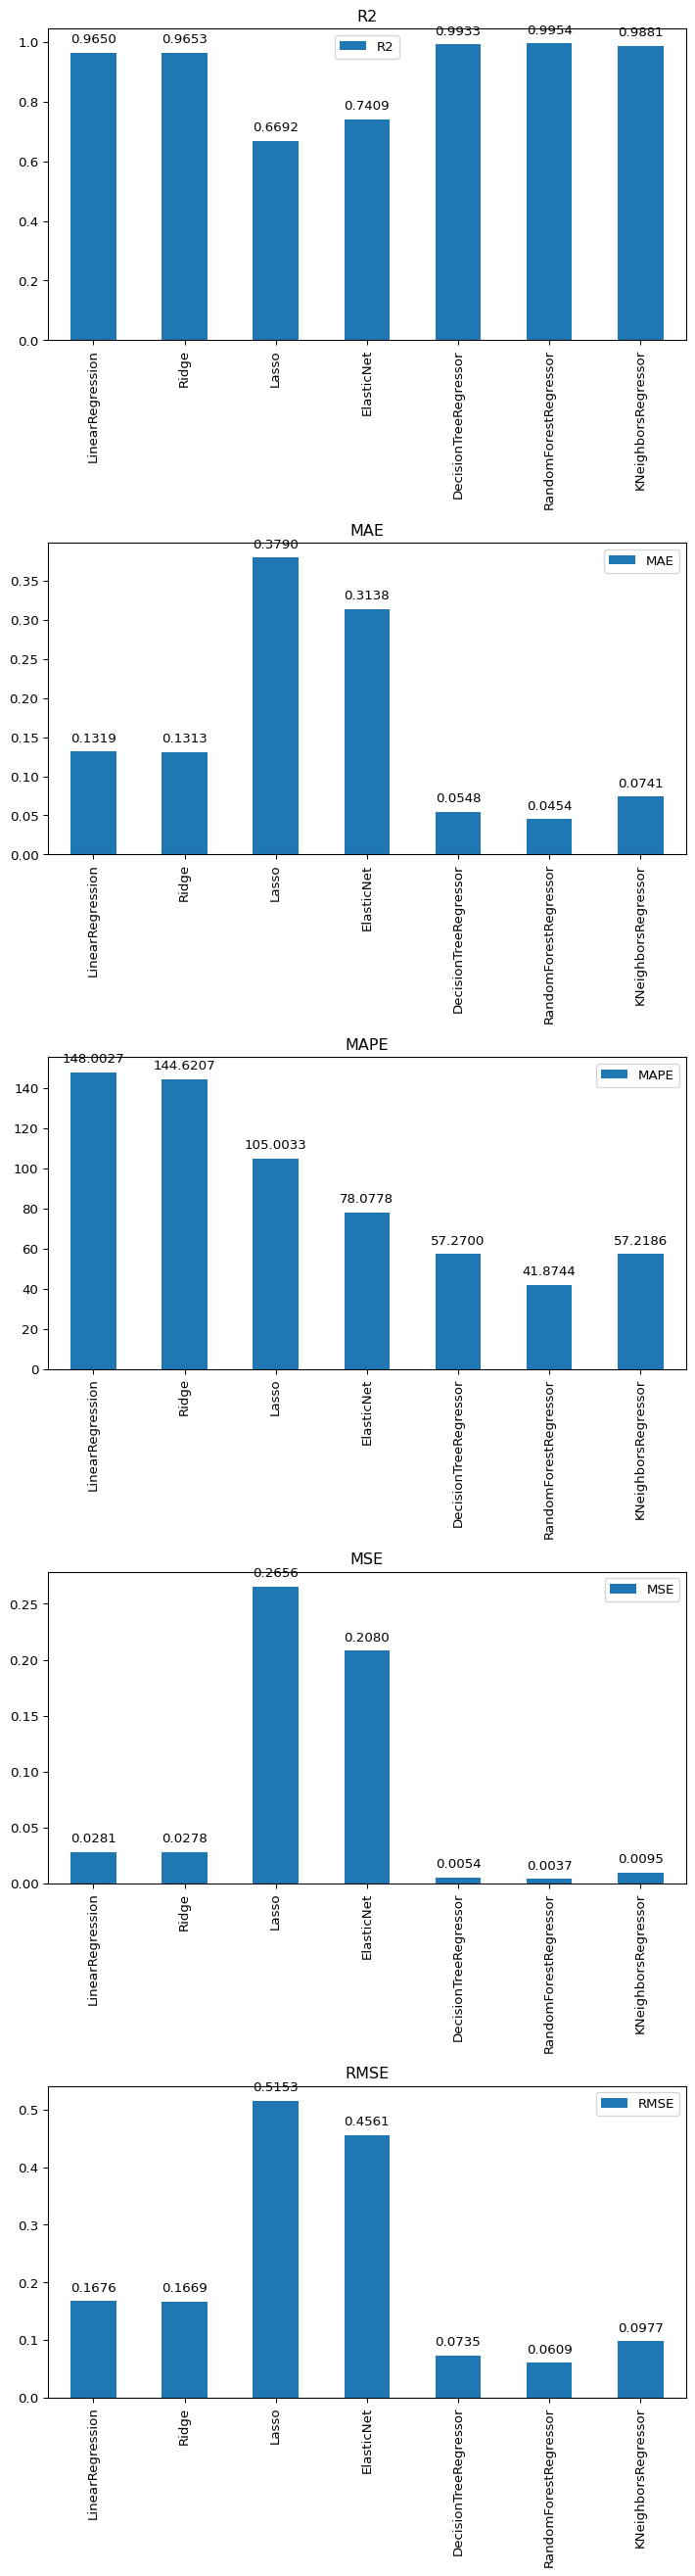

In [36]:
# Plotar gráfico de comparação das métricas de erro
metrics = ['R2', 'MAE', 'MAPE', 'MSE', 'RMSE'] # Incluindo MSE
fig, axes = plt.subplots(5, 1, figsize=(7.5, 27.5))

for i, metric in enumerate(metrics):
    results.plot(y=[metric], kind='bar', ax=axes[i])
    axes[i].set_title(metric)
    
    # Adicionando valores no topo das barras
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.tight_layout()
plt.show()

-   **`RandomForestRegressor` com melhor performance em R², MAE, MSE e
    RMSE:** Os gráficos confirmam que o `RandomForestRegressor` se
    destaca com o melhor desempenho na maioria das métricas. Ele
    apresenta o maior R², o menor MAE, o menor MSE e o menor RMSE. Isso
    reforça a indicação de que esse modelo é o mais adequado para prever
    o consumo de energia neste conjunto de dados.

-   **`DecisionTreeRegressor` com performance próxima à
    `RandomForestRegressor`:** O `DecisionTreeRegressor` também
    demonstra um bom desempenho, com valores próximos aos do
    `RandomForestRegressor` para R², MAE, MSE e RMSE. Isso indica que
    árvores de decisão conseguem capturar bem os padrões nos dados.

-   **`KNeighborsRegressor`:** O `KNeighborsRegressor` teve performance
    próxima aos dois melhores modelos em R² e RMSE. Mas em MAE e MSE,
    teve performance consideravelmente inferior.

-   **`Lasso` e `ElasticNet` com pior performance:** `Lasso` e
    `ElasticNet` apresentaram os piores resultados em todas as métricas,
    exceto no MAPE, no qual tiveram valores próximos à outros modelos
    com melhor performance. No entanto, devido ao baixo R², MAE, MSE e
    RMSE, esses modelos não são os mais adequados para o problema em
    questão.

-   **MAPE inconsistente:** O MAPE do `Lasso` e `ElasticNet` são
    significativamente menores que o MAPE da Regressão Linear e `Ridge`,
    apesar destes últimos terem melhor performance nas outras métricas.
    Como mencionado anteriormente, o MAPE pode ser problemático quando
    os valores do *target* são próximos de zero ou quando há *outliers*.
    Isso sugere que, neste caso, o MAPE pode não ser a métrica mais
    confiável para comparar os modelos, e as outras métricas (R², MAE,
    MSE e RMSE) fornecem uma avaliação mais consistente. No entanto,
    mesmo os dois melhores modelos (`DecisionTreeRegressor` e
    `RandomForestRegressor`) tiveram valores altos de MAPE, indicando
    que pode haver problemas ao estimar valores baixos do target, em
    todos os modelos testados.

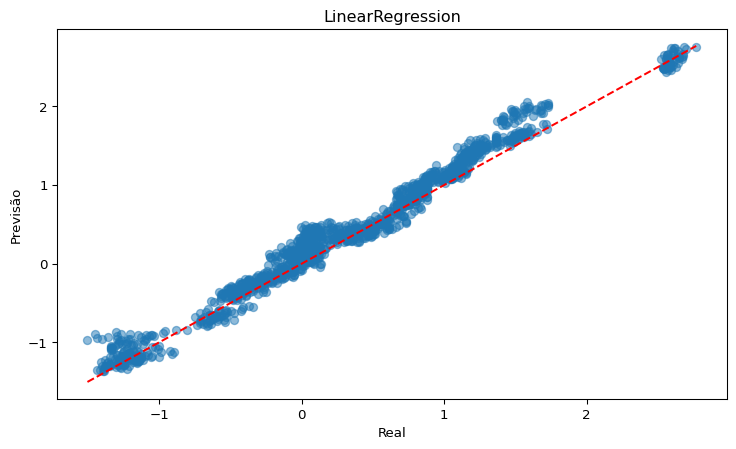

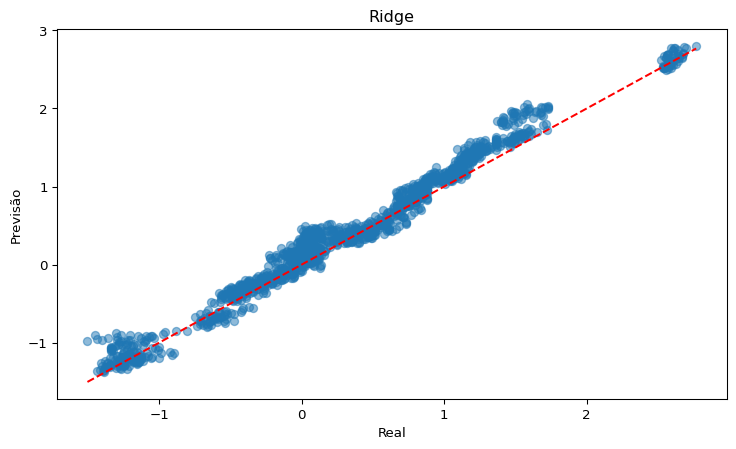

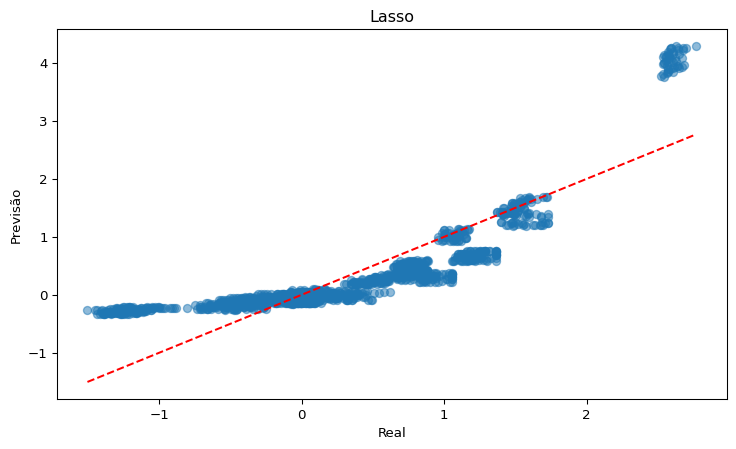

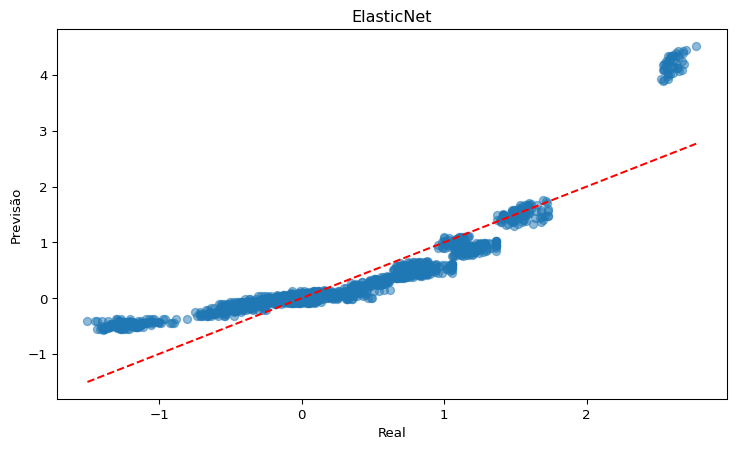

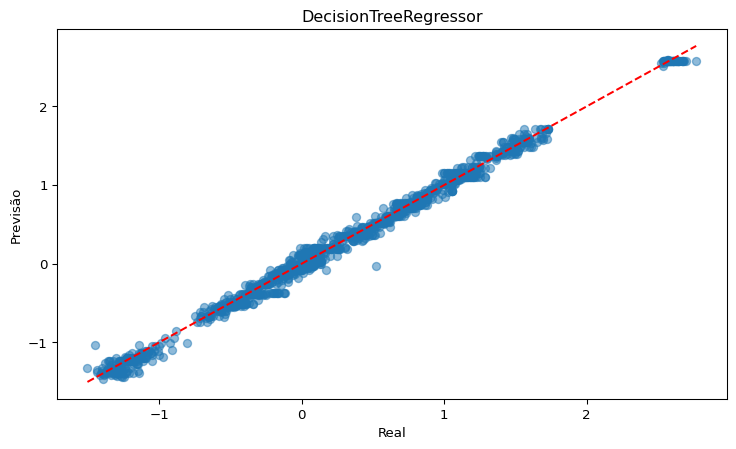

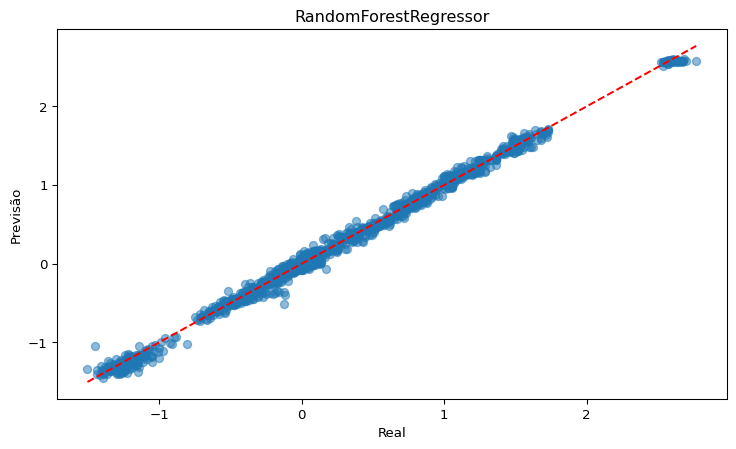

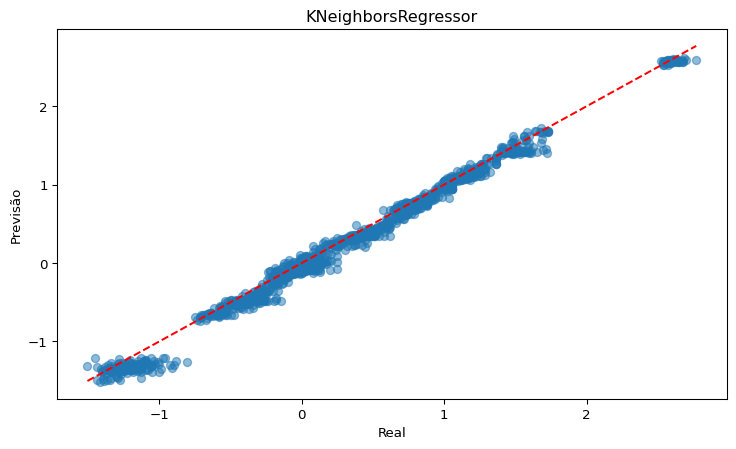

In [37]:
# Plotar gráficos de comparação entre previsões e valores reais (Scatter Plots)

for name, model in best_models.items():
    plt.figure(figsize=(9, 5))
    y_pred = model.predict(X_test)
    plt.scatter(y_test.values, y_pred, alpha=0.5)  # Alpha para transparência
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--') # Linha diagonal (y=x)
    plt.xlabel('Real')
    plt.ylabel('Previsão')
    plt.title(name)
    plt.show()

-   **`RandomForestRegressor` e `DecisionTreeRegressor` com alta
    correlação entre previsto e real:** Os pontos para o
    `RandomForestRegressor` e `DecisionTreeRegressor` se concentram mais
    próximos à linha vermelha, indicando uma forte correlação entre os
    valores reais e as previsões. Isso sugere que esses modelos
    conseguem prever com boa precisão o consumo de energia, confirmando
    as conclusões das métricas de erro.

-   **`LinearRegression`, `Ridge`, e `KNeighborsRegressor` com boa
    correlação, mas com maior dispersão:** Esses modelos também mostram
    uma boa correlação entre valores reais e previstos, mas com uma
    dispersão um pouco maior em relação à linha ideal, principalmente
    para valores mais altos. Isso indica que as previsões são menos
    precisas em comparação com o `RandomForestRegressor` e
    `DecisionTreeRegressor`.

-   **`Lasso` e `ElasticNet` com baixa correlação e com agrupamento de
    valores:** Os gráficos do `Lasso` e `ElasticNet` mostram uma
    dispersão significativa dos pontos e um agrupamento dos valores
    previstos em faixas horizontais. Isso demonstra que esses modelos
    têm dificuldade em capturar a variação nos dados e geram previsões
    menos precisas. Os pontos distantes da linha indicam erros de
    previsão maiores.

-   **Conclusões consistentes com as métricas de erro:** A análise dos
    gráficos de dispersão corrobora as conclusões obtidas a partir das
    métricas de erro, indicando que o `RandomForestRegressor` e
    `DecisionTreeRegressor` são os modelos com melhor desempenho,
    seguidos do `LinearRegression`, `Ridge`, e `KNeighborsRegressor`. O
    `Lasso` e `ElasticNet` apresentaram o pior desempenho.

## 6. Analisando os Resultados

**Precisão do Modelo:**

A precisão do modelo varia dependendo do algoritmo utilizado. O modelo
que apresentou a melhor performance foi o *RandomForestRegressor*, com
um R² de 0.995 no conjunto de teste. Isso indica que o modelo consegue
explicar 99.5% da variância nos dados, o que é um resultado excelente.
Além disso, o RMSE de 0.060 indica um erro médio baixo nas previsões na
escala logarítmica do consumo. No entanto, o MAPE de 41.84% sugere que,
apesar do baixo RMSE, ainda ocorrem erros maiores em termos percentuais,
possivelmente para valores de consumo mais baixos. O
*DecisionTreeRegressor* também obteve bons resultados, com R² de 0.993 e
RMSE de 0.076. Os demais modelos apresentaram desempenho inferior,
principalmente os modelos lineares, indicando que a relação entre as
variáveis e o consumo pode ser mais complexa do que uma simples relação
linear.

**Sugestões de Melhorias para Futuras Previsões:**

-   **Testar modelos mais complexos:** Explorar modelos mais complexos,
    como redes neurais recorrentes (RNNs, LSTMs) ou modelos de
    aprendizado profundo, pode capturar melhor as relações não lineares
    e a dependência temporal nos dados de consumo de energia.

-   **Otimização de hiperparâmetros:** Realizar uma busca mais extensa
    de hiperparâmetros, utilizando métodos como *Bayesian Optimization*
    ou algoritmos genéticos, pode levar a modelos com melhor desempenho.

-   **Análise de resíduos:** Analisar os resíduos do modelo pode revelar
    padrões não capturados e insights para melhorar a modelagem. Se os
    resíduos não forem aleatórios, isso pode indicar que há informações
    nos dados que o modelo não está capturando.

-   **Considerar a sazonalidade de forma mais explícita:** Apesar de
    termos usado variáveis *dummy* para os meses, explorar modelos que
    lidam explicitamente com sazonalidade, como SARIMA ou modelos com
    componentes sazonais, pode ser benéfico.

-   **Dados de maior granularidade:** Se possível, utilizar dados com
    maior granularidade temporal (diária ou horária) pode fornecer mais
    informações para os modelos e melhorar as previsões.

-   **Ensemble de modelos:** Combinar as previsões de diferentes modelos
    em um *ensemble* pode levar a resultados mais robustos e precisos.

-   **Analisar a performance do MAPE:** Investigar o motivo do alto
    MAPE, mesmo nos melhores modelos. Analisar os erros de previsão em
    relação aos valores reais pode ajudar a identificar se há alguma
    tendência nos erros para valores de consumo específicos. Isso pode
    indicar a necessidade de transformações adicionais nos dados ou a
    utilização de modelos mais robustos para valores de consumo mais
    baixos.

## 7. Conclusão

Este projeto demonstra o potencial do aprendizado de máquina para prever
o consumo de energia residencial no Brasil, oferecendo insights valiosos
para otimização e tomada de decisões estratégicas no setor elétrico. O
modelo *RandomForestRegressor* alcançou alta precisão (R² de 0.995),
prevendo o consumo mensal com um baixo erro médio (RMSE de 0.060 na
escala logarítmica). A análise exploratória revelou padrões importantes,
como a forte correlação entre número de consumidores e consumo, a
sazonalidade anual e a variabilidade entre estados.

**Implicações para os Negócios:**

-   **Companhias de Energia:** Previsões acuradas permitem otimizar a
    geração e distribuição, minimizando custos e desperdícios. A
    granularidade por estado possibilita adaptar as estratégias
    regionais, garantindo o fornecimento estável e evitando apagões. As
    previsões também podem ser integradas em sistemas de precificação
    dinâmica, otimizando a receita e incentivando o uso eficiente da
    energia. Além disso, a previsão de demanda auxilia na tomada de
    decisões sobre investimentos em infraestrutura, como a expansão da
    rede de distribuição e a incorporação de novas fontes de energia.

-   **Governo e Órgãos Reguladores:** Previsões confiáveis são
    fundamentais para o planejamento energético nacional e regional,
    guiando políticas de eficiência energética, investimentos em fontes
    renováveis e a regulação do setor. A identificação de padrões de
    consumo por estado permite direcionar políticas públicas e alocar
    recursos de forma eficiente, promovendo o desenvolvimento
    sustentável do setor energético. As previsões também podem ser
    usadas para simular cenários e avaliar o impacto de diferentes
    políticas e regulamentações.

-   **Consumidores e Comercializadoras:** A previsão de consumo em
    escala estadual e nacional oferece às comercializadoras de energia
    uma vantagem competitiva, permitindo otimizar a compra e venda de
    energia, gerenciar riscos e desenvolver ofertas personalizadas para
    os consumidores. Ferramentas baseadas em previsões podem ajudar os
    consumidores a monitorar e controlar seus gastos com energia,
    incentivando o consumo consciente e a adoção de práticas mais
    sustentáveis. Além disso, previsões precisas podem ser utilizadas
    para desenvolver sistemas de automação residencial, otimizando o uso
    de energia em tempo real.

-   **Investidores:** A capacidade de prever o consumo de energia com
    precisão fornece informações cruciais para investidores no setor
    elétrico, permitindo avaliar o potencial de mercado, estimar
    retornos de investimentos e tomar decisões mais informadas sobre
    projetos de geração, transmissão e distribuição de energia.

Em resumo, este projeto demonstra que a previsão de consumo de energia
residencial, utilizando aprendizado de máquina, oferece insights
acionáveis para diversos atores do setor elétrico, contribuindo para a
eficiência, sustentabilidade e desenvolvimento estratégico do mercado. A
incorporação de dados adicionais e a exploração de modelos mais
complexos podem refinar ainda mais as previsões e ampliar seu potencial
de aplicação.